# Open Traffic Reporter - Part III

##  Regional Map-Matching Performance

So far we have seen that map-matching accuracy can be affected by both variables we can fix over time (e.g. GPS sample rate) and those we cannot (e.g. GPS accuracy/noise). The ability to control sampling rate allows us measure its impact on match error and make recommendations to data providers based on the trade-offs between the two. Conversely, because GPS accuracy is so highly variable, we must make a more nuanced decision about the range of expected noise levels that we for which we wish to optimize the algorithm. 

A third kind of variable that impacts map-matching performance are those related to the built environment. Like GPS sample rate, built environment characteristics remain fixed in the short term. However, like GPS _accuracy_, we have no control over these variables; they are quite literally built into the environment. Thus, despite our intuition that denser network structures may negatively impact match performance, we cannot recommend that a data provider should build a less dense road network.

Nevertheless, it is still worthwhile to quantify this intuition about the relationship between road network density and map-matching performance for two principal reasons: 
1. to set expectations for both our users and data providers based on characteristics specific to their region (i.e. determine the upper limit of performance)
2. to make more informed decisions about how conservative we want to be when choosing which data to keep and which to throw away (e.g. picking a [speed error threshold](www.fake.com)). 

In the following analysis, we will rely on road network density as a proxy for the character of the built environment. Road network density reflects a number of highly relevant environmental characteristics including land use types, city block size, and the prevalence of [urban canyons](https://en.wikipedia.org/wiki/Street_canyon). 

The analysis will proceed in two parts. First, we will assess the match rates of individual road segments as a function of the local road network density at that segment. Second, having established the relationship between density and map-matching performance on the smallest of scales, we will undertake a case study comparing the regional performance across two cities with very different road network structures.

In [46]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects, rcParams
import numpy as np
import os
import glob
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import HTML, Image
import osmnx as ox

In [12]:
sns.set_style({
    'font.family': ['DejaVu Sans'],
    'axes.facecolor': 'white',
    'axes.grid': False,
    'axes.linewidth': 1,
    'axes.edgecolor': 'black',
    'xtick.major.size': 5,
    'xtick.direction': 'out',
    'ytick.major.size': 5,
    'ytick.direction': 'out'})
ox.config(log_file=True, log_console=True, use_cache=True)
%matplotlib inline
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
img_folder = 'images'
extension = 'png'
size = 240
dpi = 40

## 1. Segment-level Analysis

By sampling routes across a variety of different U.S. cities we ensure that our segments will span the entire range of density types. Here we have selected 15 cities of varying sizes and dominant land use patterns.

####  Generate Routes

In [51]:
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 1

In [52]:
allRoutes = []
for cityName in cities:
    try:
        routeList = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, apiKey=mapzenKey)
        allRoutes += routeList
        print cityName
        print()
print('Generated {0} routes from {1} cities'.format(len(allRoutes), len(cities)))

Sioux Falls, SD
Dallas, TX
Seattle, WA
Chicago, IL
Palm Springs, CA
Generated 10 routes from 15 cities


#### Save routes or load previous routes

In [3]:
allRoutes = pickle.load(open('multicity_routes_07_24.pkl'.format('San Francisco'),'rb'))

In [7]:
pickle.dump(allRoutes, open('multicity_routes_07_24.pkl'.format(cityName),'wb'))

#### Generate match scores for all routes

In this disaggregate analysis, we don't care about what city or route each segment match came from. We want to pool all our segments and determine whether segments that were matched have a different distribution of road network densities than those segments that were not matched

In [9]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = [0, 20, 40, 60, 80, 100]   # specified in meters

In [2]:
matchDf, speedDf, densityDf = val.get_route_metrics(allRoutes, sampleRates, noiseLevels, saveResults=False)

#### Save density scores or load previous scores

In [4]:
densityDf = pd.read_csv('../data/multicity_densities_07_24.csv')

In [8]:
densityDf.to_csv('../data/multicity_densities_07_24.csv',index=False)

The content of the density dataframe is summarized below:

In [6]:
densityDf.describe(include='all')

,density,sample_rate,noise,matched
count,890130.000000,890130.000000,890130.000000,890130
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,752927
mean,10.365778,13.200000,50.000000,NaN
std,2.490232,10.533761,34.156522,NaN
min,3.000000,1.000000,0.000000,NaN
25%,8.000000,5.000000,20.000000,NaN
50%,10.000000,10.000000,50.000000,NaN
75%,12.000000,20.000000,80.000000,NaN


#### Compare the distribution of road network densities by match type

Kernel density estimates (KDEs) provide a nice way to estimate and visualize the probability distribution of a random variable (the word density here refers to a probability density, not to be confused with road network density which is the variable we are modeling). A KDE is estimated, in essence, by applying a rolling average to a frequency distribution or histogram, with the "kernel" loosely defined as the window used as that rolling average. 

Our hypothesis, derived from the intution that higher densities are more prone to erroneous matches, is that the KDE of road network densities around successfully matched segments should be skewed towards lower values relative to the KDE of densities derived from unmatched segments.

The KDE's for our two distributions are shown here:

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans



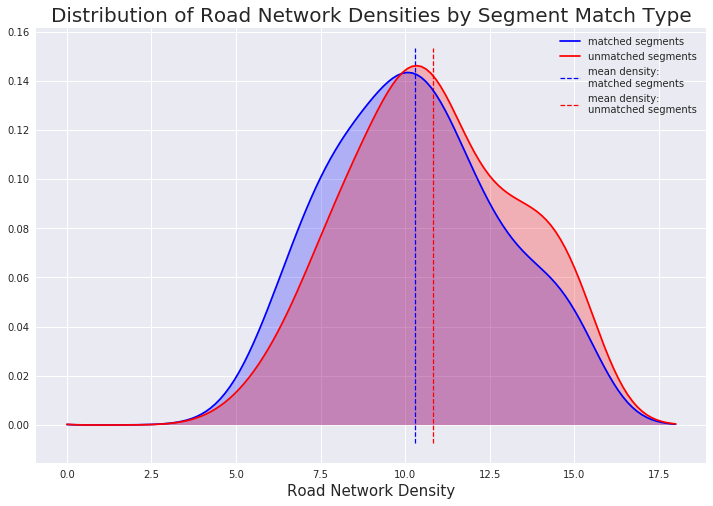

In [5]:
val.plot_density_kdes(densityDf)

The chart above shows that the distribution of road network densities are actually much more similar than we might expect. It suggests that road network density on its own would not make a good predictor of match rate. 

There is, however, a clear difference between the distributions, albeit somewhat small in magnitude. Most importantly, this difference is in the direction that matches our intuition: unmatched segments have a higher mean road network density than their matched counterparts. Given that the distributions were calculated over such a wide swath of sample data -- nearly 900,000 individual road segments from 750 routes in 15 different cities -- we can be confident that the trend is real.

Drilling down a bit deeper, we see that this trend persists across different GPS sample rates and noise levels: 

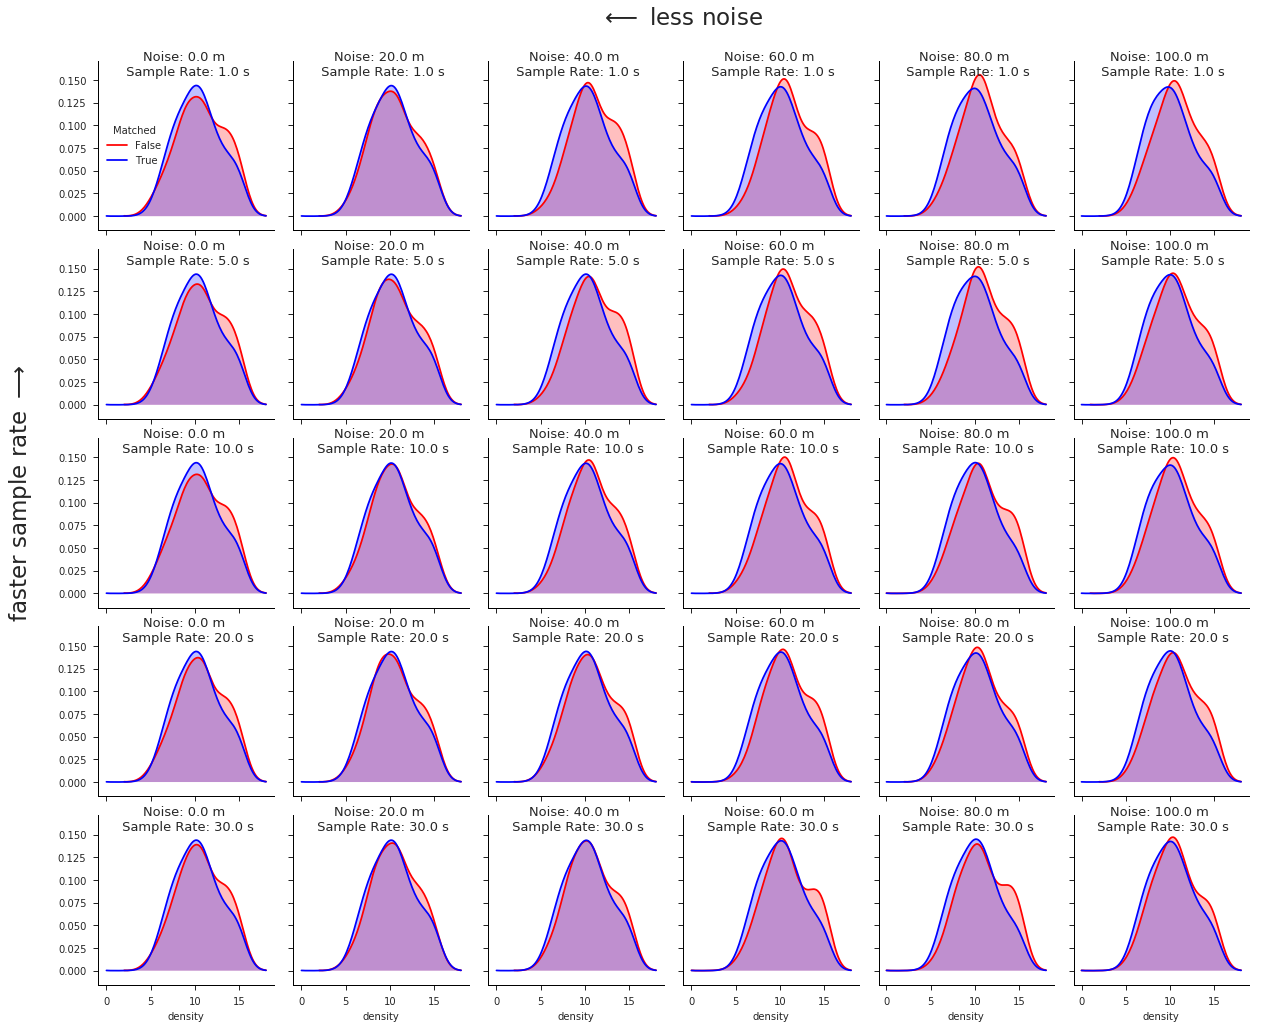

In [6]:
val.plot_density_kdes_gridded(densityDf, saveFig=True)

Although the evidence so far does suggest a weakly negative influence of road network density on map-matching performance, the actual empirical relationship between the two is somewhat obscured by the KDE's. Since KDE plots are essentially visualizing a frequency distribution, we may be missing important visual information in the tails of the distributions where there simply aren't as many data points.

Since we don't really care about the frequency with which different road network densities occur, but rather how these densities impact map-matching performance when they _do_ occur, we can normalize our results by the number of segments we observed at each road network density level (1 - 16)

In [10]:
freqDf = pd.DataFrame(columns=['sample_rate','noise','density','matched','frequency'])
for r, rate in enumerate(sampleRates):
    for n, noise in enumerate(noiseLevels):
        rateDensityDf = densityDf[(densityDf['sample_rate'] == rate) & 
                                  (densityDf['density'] > 5) & 
                                  (densityDf['noise'] == noise)]
        densityMatchCounts = rateDensityDf.groupby(['density','matched']).count().reset_index().\
            drop('sample_rate', 1).rename(columns={'noise':'count'})
        densityCounts = rateDensityDf.groupby(['density']).count().reset_index().\
            drop(['matched', 'noise'],1).rename(columns={'sample_rate':'total_count'})
        merged = pd.merge(densityMatchCounts, densityCounts)
        merged['pct'] = merged['count'] / merged['total_count']
        merged = merged[merged['total_count'] > 100]
        merged['sample_rate'] = rate
        merged['noise'] = noise
        merged.rename(columns={'pct':'frequency'}, inplace=True)
        freqDf = pd.concat((freqDf, merged[['sample_rate','noise','density','matched','frequency']]), ignore_index=True)

The first six rows of our new table:

In [11]:
freqDf.head(6)

,sample_rate,noise,density,matched,frequency
0,1.0,0.0,6.0,False,0.026840
1,1.0,0.0,6.0,True,0.973160
2,1.0,0.0,7.0,False,0.023459
3,1.0,0.0,7.0,True,0.976541
4,1.0,0.0,8.0,False,0.022006
5,1.0,0.0,8.0,True,0.977994


Now that we are dealing with the match frequency by sample rate, noise level, and road network density, there is no need to visualize both the matched and unmatched rates since they will always sum to 1. Instead, we will focus our attention on the percentage of _unmatched_ segments at each discrete variable level because we are primarily interested in the relationship between road network density and match error.

Plotting just the frequencies of segments with `matched == False`, normalized to 1 for each combination of sample rate, noise, and road network density, we arrive at the following:

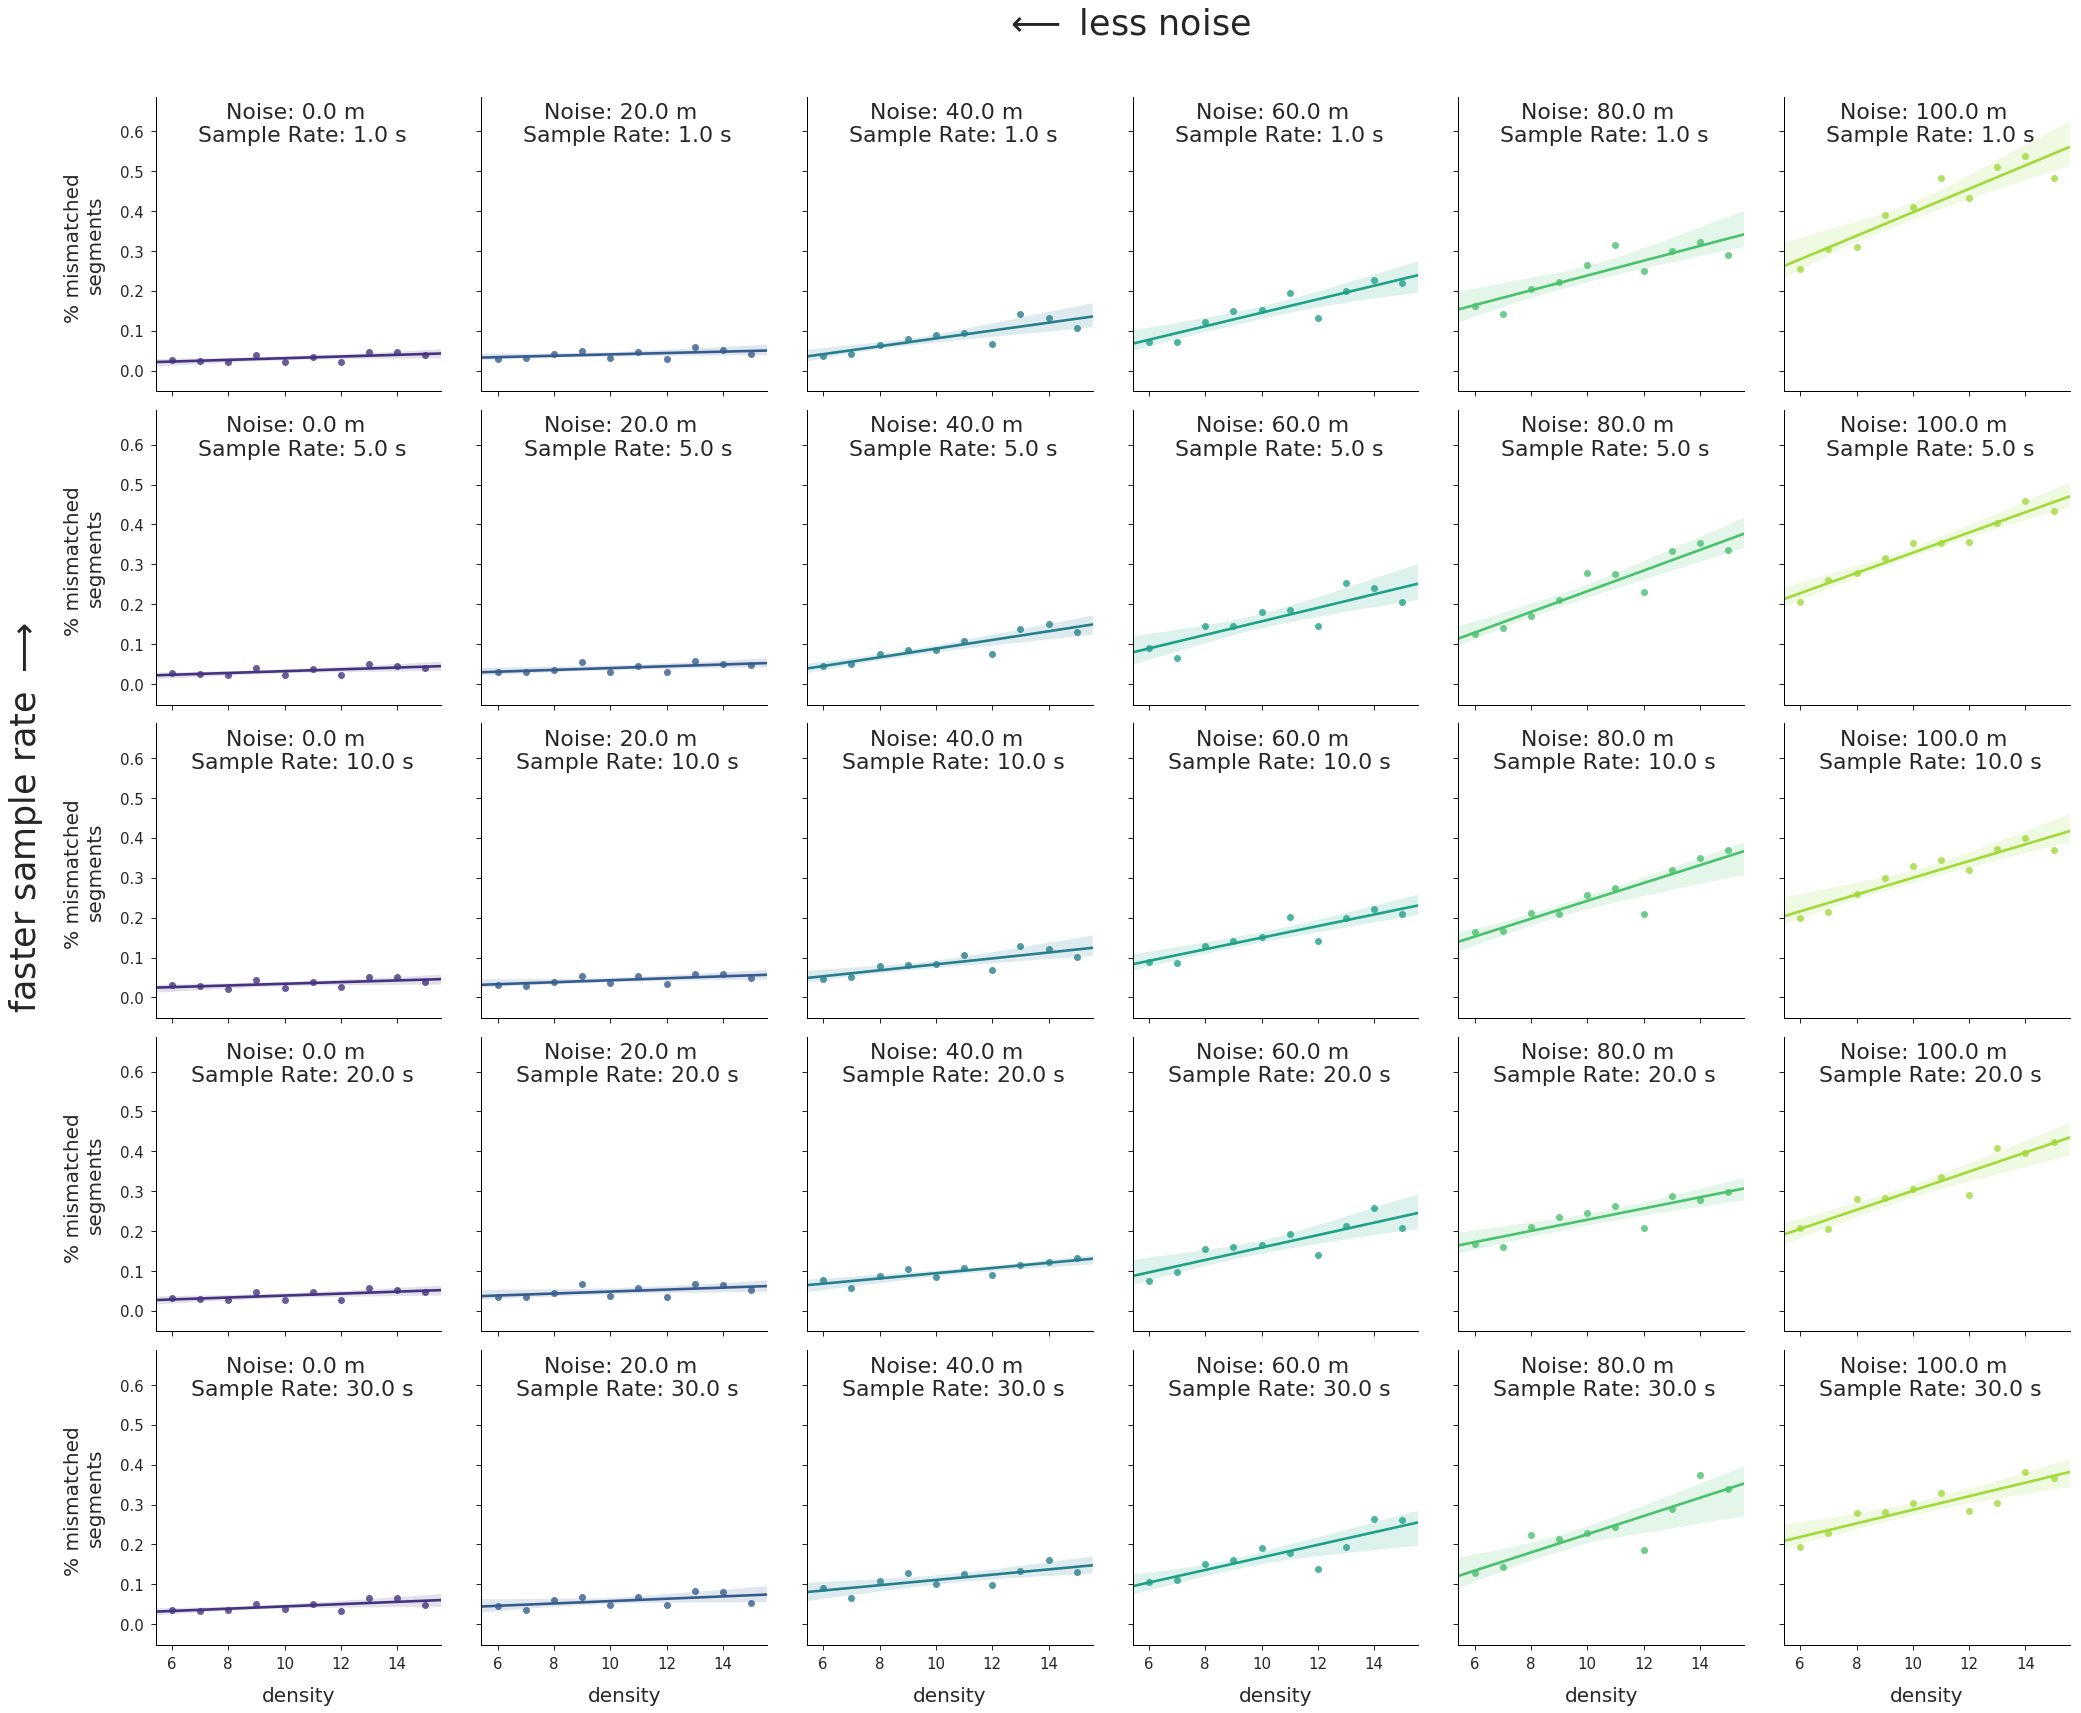

In [12]:
val.plot_density_regressions(freqDf)

These charts highlight a number of noteworthy trends. First, there is a clear positive correlation between road network density on the `X` axes and error rate on the `Y` axes for the majority of noise levels and sample rates. What this tells us is that for a given measurement collected with a given amount of GPS noise at a given sample rate, the denser the road network is around that measurement, the more likely our map-matcher is to misidentify  the segment of the road network to which that measurement belongs. In other words, _**the greater the density of the road network the worse the map-matching results will be**_. This may seem obvious, but it is extremely important to understand that there are structural limitations associated with certain land use types that undercut the performance of even the most technologically advanced map-matching solutions. Both data providers and end users should understand that map-matching will be less accurate in downtown locations than out in the suburbs (ideally, the volume of traffic generating data in a busy central business district should more than make up for the discrepancy in accuracy).  

The second trend to note is that the correlation between road network density and match error rate increases with increasing noise, from nearly 0 correlation at the lowest levels of noise to a trendline of nearly 3% error per unit of density at 100 m of GPS noise. In terms of real numbers, a route with an average density of 12 could expect up to **12%** more mismatches than a route traversed in a area with a road network density of ~8. 

<table>
    <caption align="bottom">1 Sq. Mile from each road network (generated using <href>[osmnx](https://github.com/gboeing/osmnx)</href>)</caption>
    <tr>
        <td>
            <img src='images/irvine2.png'>
            <figcaption>Irvine, CA - Density: ~8</figcaption>
        </td>
        <td>
            <img src='images/sf2.png'>
            <figcaption>SF, CA - Density: ~12</figcaption>
        </td>
    </tr>
</table>

The most obvious trend seen in the charts, however, is one we're not actually interested in: error rate increases with GPS noise. We have already assessed the impact of GPS noise on match accuracy, thus the relative positions of the regression lines on the `Y` axes in the charts only serve as a distraction.

The process of data _standardization_ first centers each distribution about its own mean and then scales the values within the distribution relative to the standard deviation of the distribution. By standardizing our data in this way, we can visualize our data on a single set of axes that highlights just the change in slope between the trendlines at varying levels of GPS noise:

In [13]:
typeMatchCounts = densityDf.groupby(['sample_rate','noise','density','matched']).size().reset_index().rename(columns={0:'count'})
typeCounts = densityDf.groupby(['sample_rate','noise','density']).size().reset_index().\
            rename(columns={0:'total_count'})
merged = pd.merge(typeMatchCounts, typeCounts)
merged['pct_by_match_type'] = merged['count'] / merged['total_count']
mergedMatches = merged[(merged['matched'] == False) & (merged['density'] > 5)]
mergedMatches = mergedMatches[['sample_rate','density','noise','pct_by_match_type']]
aggStatsMatchPct = mergedMatches.groupby(['sample_rate','noise']).agg({'pct_by_match_type':{'mean_match_pct':'mean','stddev_match_pct':'std'}})
aggStatsMatchPct.columns = aggStatsMatchPct.columns.droplevel(0)
aggStatsMatchPct.reset_index(inplace=True)
aggStatsMerged = pd.merge(mergedMatches, aggStatsMatchPct, on=['sample_rate','noise'])
aggStatsMerged['match_rate_normed'] = ((
    aggStatsMerged['pct_by_match_type'] - aggStatsMerged['mean_match_pct']) / aggStatsMerged['stddev_match_pct']).round(2)
aggStatsMerged['above_avg'] = aggStatsMerged['match_rate_normed'] > 0

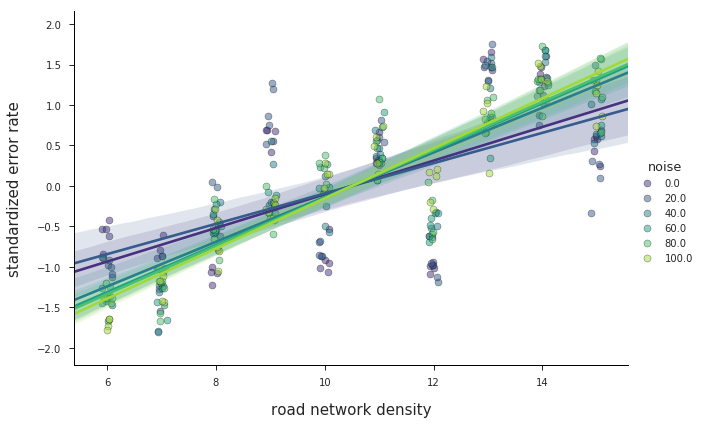

In [14]:
sns.set_style({
        'font.family': ['DejaVu Sans'],
        'axes.facecolor': 'white',
        'axes.grid': False,
        'axes.edgecolor': 'black',
        'axes.labelsize': 15,
        'xtick.major.size': 5,
        'xtick.direction': 'out',
        'ytick.major.size': 5,
        'ytick.direction': 'out',
        'axes.linewidth': 1,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.labelpad': 15,
        'axes.titlepad': -45})
g = sns.lmplot('density','match_rate_normed', aggStatsMerged, hue='noise', size=6, aspect=1.5, palette='viridis',
              x_jitter=0.1, scatter_kws={'alpha':0.5, 'edgecolor':'k', 'linewidths':0.5})
g.set_ylabels('standardized error rate')
g.set_xlabels('road network density')

With standardized data, we can more clearly see how road network density exerts an increasingly negative effect on segment match error rate as the level of GPS noise increases. The actual values on the `Y` axis, however, are unitless, and therefore less easily interpreted.

For some bonus eye candy, we can represent the same data with an interative parallel coordinates plot (as suggested by our good buddy [Will Geary](https://willgeary.github.io/)). This interactive mode of visualization allows us to dynamically filter our data to see how certain variables interact with others. In graph below, drag the pink line up and down on the road network density axis and watch how the range of standardized error rates change in response:

In [15]:
data = [
    go.Parcoords(
        line = dict(color = aggStatsMerged['noise']),
        dimensions = list([
            dict(constraintrange = [6,8],
                 label = 'Road Network Density', values = aggStatsMerged['density'],
                tickvals = aggStatsMerged['density'].unique()),
            dict(constraintrange = [1,30],
                 label = 'Sample Rate (s)', values = aggStatsMerged['sample_rate'],
                tickvals = aggStatsMerged['sample_rate'].unique()),
            dict(constraintrange = [0,100],
                 label = 'Noise (m)', values = aggStatsMerged['noise'],
                tickvals = aggStatsMerged['noise'].unique()),
            dict(
                 label = 'Standardized Error Rate', values = aggStatsMerged['match_rate_normed'])
            
        ]),
        opacity=0.5,
        labelfont = dict(size = 13)
    )
]

py.iplot(data, filename = 'parcoords-advanced')

You can also draw your own filters on the other axes by clicking and dragging to draw your own pink filters.

## 2. Case Study: Irvine, CA vs. San Francisco, CA

Clearly the built environment has a significant impact on the likelihood of matching a GPS measurement to its correct road segment. This is a particularly notable finding not just because a data provider/end user might expect worse performerance in the denser portions of their service areas, but because two different data providers/end users might expect entirely different performance based on the general character of their service territories. 

#### Irvine, California

Irvine is a an affluent, planned city in southern California, just south of Los Angeles. It was planned by the [Irvine Company](https://en.wikipedia.org/wiki/Irvine_Company), which continues to control development in the area. Irvine is home to UC Irvine, which is also the city's largest employer. The city has a population density of 4,057.85/sq mi according to [Wikipedia](https://en.wikipedia.org/wiki/Irvine,_California).

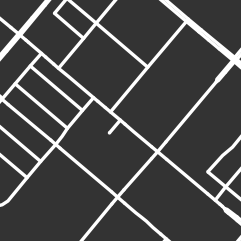

In [17]:
place = 'irvine'
point = (33.694981, -117.841375)
fig, ax = ox.plot_figure_ground(point=point, filename=place, network_type='drive', default_width=6, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

#### San Francisco, California

San Francisco is the second most densely populated major city in the United States, with a population density of 17,246.4/sq mi according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population_density). It is perhaps _the_ major west coast hub for the financial and technology sectors, and is entirely contained within a peninsula roughly 7 miles by 7 miles. 

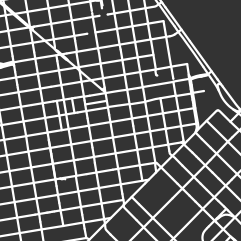

In [16]:
place = 'sf'
point = (37.793897, -122.402189)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi, network_type='drive')
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

In [18]:
cityName = 'Irvine, CA'
routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

In [19]:
pickle.dump(routeList, open('irvine_100_routes.pkl','wb'))

In [ ]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
irvMatchDf, irvSpeedDf, irvDensityDf = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [26]:
laMatchDf.to_csv('la_routes_100.csv', index=False)

In [10]:
laMatchDf = pd.read_csv('la_routes_100.csv')

In [12]:
laMatchDf['avg_density'].mean()

11.71181535237873

In [32]:
cityName = 'Manila, Philippines'
routeList = val.get_POI_routes_by_length(cityName, 1, 5, 100, gmapsKey)

In [35]:
pickle.dump(routeList, open('manila_routes.pkl','wb'))

In [4]:
routeList = pickle.load(open('manila_routes.pkl', 'rb'))

In [5]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
manilaMatchDf, _, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [6]:
manilaMatchDf.to_csv('manila_routes_100.csv', index=False)

In [13]:
manilaMatchDf['avg_density'].mean()

11.093604561053944

In [15]:
cityName = 'Atlanta, GA'
routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

In [ ]:
pickle.dump(routeList, open('atl_routes_100.pkl','wb'))

In [3]:
routeList = pickle.load(open('atl_routes_100.pkl','rb'))

In [4]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
atlMatchDf, _, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [14]:
atlMatchDf.to_csv('atl_routes_100.csv', index=False)

In [7]:
atlMatchDf['avg_density'].mean()

10.077456109701721

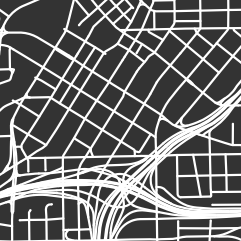

In [10]:
place = 'Atlanta, GA'
fig, ax = ox.plot_figure_ground(address=place, filename=place, network_type='drive', dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

In [11]:
cityName = 'Irvine, CA'
routeList = val.get_routes_by_length(cityName, 1, 5, 200, mapzenKey)

In [12]:
pickle.dump(routeList, open('irvine_routes_200.pkl','wb'))

In [ ]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
irvineMatchDf, _, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [ ]:
irvineMatchDf.to_csv('irvine_routes_200.csv', index=False)